In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

MAX_ROWS = 10_855_959

# `annotation_timing.log`

In [2]:
# Read log file
f = open('annotation_timing.log', 'r')
raw_data = f.read()
f.close()

raw_data = raw_data.split('**********')
df_size_timing, unannotated_memory, bin_num_timing, annotated_memory = raw_data

In [3]:
# Time to annotate DataFrames of different sizes using pd.cut()
s = pd.Series(df_size_timing.split('\n'))

regex = r'Time to annotate (\d+) rows: (\d+\.\d+) ms'

df = s.str.extractall(regex)
df = df.set_index(df.index.levels[0])
df.index.name = 'index'
df = df.rename(columns={0: 'df_rows', 1: 'time (ms)'})

df['df_rows'] = df['df_rows'].astype(int)
df['time (ms)'] = df['time (ms)'].astype(float)

# df.to_csv('annotation_timing_df_size.csv')

df


,df_rows,time (ms)
index,,
0,10,0.546336
1,100,0.551659
2,1000,0.530759
3,10000,0.602878
4,100000,1.219015
5,1000000,11.282075
6,10855959,124.508751


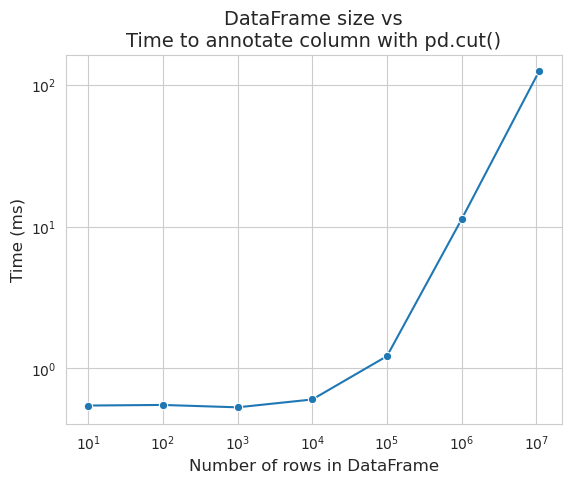

In [4]:
sns.set_style('whitegrid')
ax = sns.lineplot(data=df, x='df_rows', y='time (ms)', marker='o')
ax.set(xscale='log', yscale='log')

ax.set_xlabel('Number of rows in DataFrame', size=12)
ax.set_ylabel('Time (ms)', size=12)
ax.set_title('DataFrame size vs\nTime to annotate column with pd.cut()', size=14)

plt.show()

In [5]:
# Time to annotate DataFrames using different numbers of bins
s = pd.Series(bin_num_timing.split('\n'))

regex = r'Time to annotate data with (\d+) bins: (\d+\.\d+) ms'

df = s.str.extractall(regex)
df = df.set_index(pd.Index(range(len(df)), name='index'))
df = df.rename(columns={0: 'bins', 1: 'time (ms)'})

df['bins'] = df['bins'].astype(int)
df['time (ms)'] = df['time (ms)'].astype(float)

# df.to_csv('annotation_timing_bin_num.csv')
df

,bins,time (ms)
index,,
0,2,99.870847
1,4,106.374781
2,8,110.308348
3,16,120.340980
4,32,131.447273
5,64,154.516321


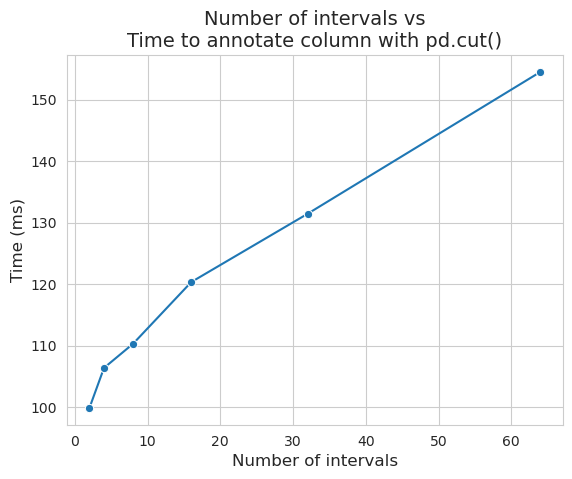

In [6]:
sns.set_style('whitegrid')
ax = sns.lineplot(data=df, x='bins', y='time (ms)', marker='o')

ax.set_xlabel('Number of intervals', size=12)
ax.set_ylabel('Time (ms)', size=12)
ax.set_title('Number of intervals vs\nTime to annotate column with pd.cut()', size=14)

plt.show()

In [7]:
# Memory usage of unannotated and annotated DataFrames
s = pd.Series(re.split(r'----------DataFrame----------', annotated_memory))

regex_mem = r'memory usage: (\d+\.\d+)\+* MB'

df_mem = s.str.extractall(regex_mem)
df_mem = df_mem.unstack()
df_mem.columns = df_mem.columns.droplevel(0)
df_mem.columns.name = None
df_mem = df_mem.rename(columns={0: 'df_mem (MB)', 1: 'annot_mem (MB)'})
df_mem = df_mem.set_index(pd.Index(range(len(df_mem)), name='index'))

df_mem['bins'] = pd.Series([2, 4, 8, 16, 32, 64])
df_mem['df_mem (MB)'] = df_mem['df_mem (MB)'].astype(float)
df_mem['annot_mem (MB)'] = df_mem['annot_mem (MB)'].astype(float)

regex_overhead = r'Categorical overhead:  (\d+) bytes'

df_overhead = s.str.extractall(regex_overhead)
df_overhead = df_overhead.set_index(pd.Index(range(len(df_overhead)), name='index'))
df_overhead = df_overhead.rename(columns={0: 'cat_mem (bytes)'})

df_overhead['cat_mem (bytes)'] = df_overhead['cat_mem (bytes)'].astype(int)

df = pd.merge(df_mem, df_overhead, left_index=True, right_index=True)
df.to_csv('annotation_timing_memory.csv')
df

,df_mem (MB),annot_mem (MB),bins,cat_mem (bytes)
index,,,,
0,403.8,10.4,2,140
1,403.8,10.4,4,236
2,403.8,10.4,8,428
3,403.8,10.4,16,812
4,403.8,10.4,32,1584
5,403.8,10.4,64,3128


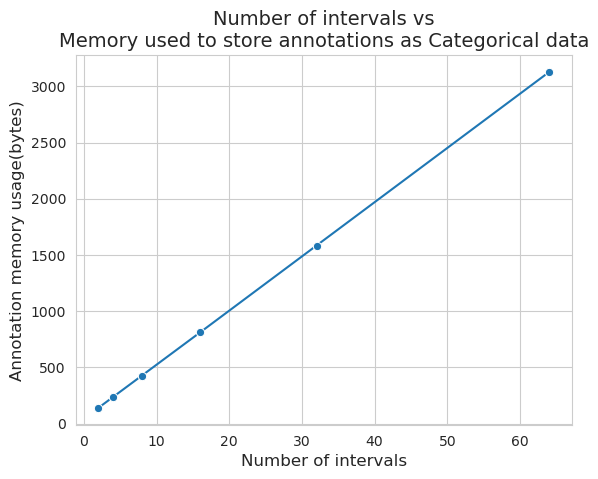

In [8]:
sns.set_style('whitegrid')
ax = sns.lineplot(data=df, x='bins', y='cat_mem (bytes)', marker='o')

ax.set_xlabel('Number of intervals', size=12)
ax.set_ylabel('Annotation memory usage(bytes)', size=12)
ax.set_title('Number of intervals vs\nMemory used to store annotations as Categorical data', size=14)

plt.show()

# `filter_timing_xxx.log`

## `filter_timing_equals.log` and `filter_timing_isin.log`

In [9]:
def read_filter_log(file, num_rows, sketch_sizes, filters):
    # Read log file
    f = open(file, 'r')
    raw_data = f.read()
    f.close()

    raw_data = raw_data.split('NUM ROWS')[1:]
    
    # Process file contents
    df = pd.DataFrame(columns=['nrows', 'sk_size'])

    for irows, nrows in enumerate(num_rows):
        for isk, sk_size in enumerate(sketch_sizes):
            raw_data_i = raw_data[irows].split('**********')
            s = pd.Series(raw_data_i[isk])

            regex_time_a = r'filter\da time: (\d+.\d+) ms'
            regex_time_b = r'filter\db time: (\d+.\d+) ms'
            regex_size_a = r'filter\da size: \((\d+, \d+)\)'
            regex_size_b = r'filter\db size: \((\d+, \d+)\)'

            dfi_time_a = s.str.extractall(regex_time_a)
            dfi_time_b = s.str.extractall(regex_time_b)
            dfi_size_a = s.str.extractall(regex_size_a)
            dfi_size_b = s.str.extractall(regex_size_b)

            idx_level_0 = pd.Index([sk_size] * len(dfi_time_a), name='sk_size')
            idx_level_1 = pd.Index(dfi_time_a.index.levels[1].map(dict(zip(range(len(filters)), filters))), name='filter')

            dfi_time_a = dfi_time_a.set_index([idx_level_0, idx_level_1]).set_axis(['time (ms)'], axis=1)
            dfi_time_b = dfi_time_b.set_index([idx_level_0, idx_level_1]).set_axis(['time (ms)'], axis=1)
            dfi_size_a = dfi_size_a.set_index([idx_level_0, idx_level_1]).set_axis(['size'], axis=1)
            dfi_size_b = dfi_size_b.set_index([idx_level_0, idx_level_1]).set_axis(['size'], axis=1)

            dfi_a = pd.concat([dfi_time_a, dfi_size_a], axis=1)
            dfi_b = pd.concat([dfi_time_b, dfi_size_b], axis=1)

            dfi_a['ab'] = 'a'
            dfi_b['ab'] = 'b'
            dfi = pd.concat([dfi_a.reset_index(), dfi_b.reset_index()], axis=0)
            dfi['nrows'] = nrows
            
            df = pd.concat([df, dfi], axis=0)
            
    # df.to_csv('filter_timing_equals.csv')

    df['nrows'] = df['nrows'].astype(int)
    df['sk_size'] = df['sk_size'].astype(int)
    df['time (ms)'] = df['time (ms)'].astype(float)

    return df

num_rows = [10, 100, 1000, 10_000, 100_000, 1_000_000, 10_855959]
sketch_sizes = [1, 2, 4, 8]
filters = ['filter1', 'filter2', 'filter3', 'filter4']

df_equals = read_filter_log('filter_timing_equals.log', num_rows, sketch_sizes, filters)
df_isin = read_filter_log('filter_timing_isin.log', num_rows, sketch_sizes, filters)

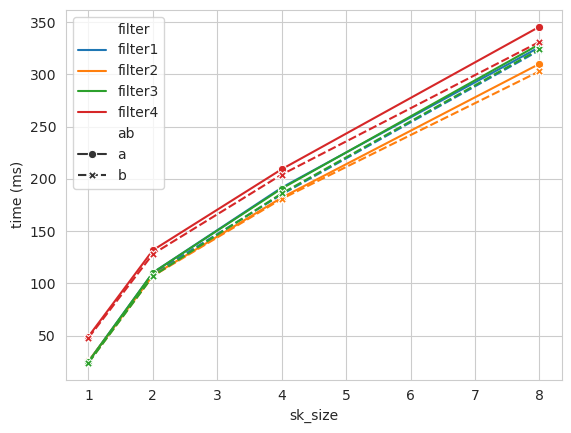

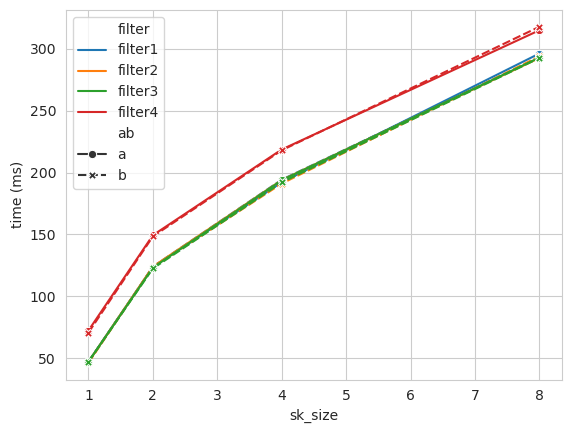

In [10]:
def time_vs_sketch_size(df, nrows, ab=True):
    sns.set_style('whitegrid')
    if ab:
        ax = sns.lineplot(data=df[df['nrows'] == nrows], x='sk_size', y='time (ms)', hue='filter', style='ab', markers=True)
    else:
        ax = sns.lineplot(data=df[df['nrows'] == nrows], x='sk_size', y='time (ms)', hue='filter', markers=True)
    
    plt.show()
    
time_vs_sketch_size(df_equals, 10_855_959)
time_vs_sketch_size(df_isin, 10_855_959)

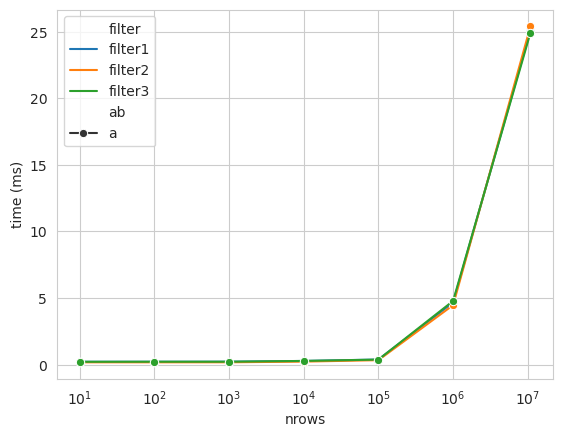

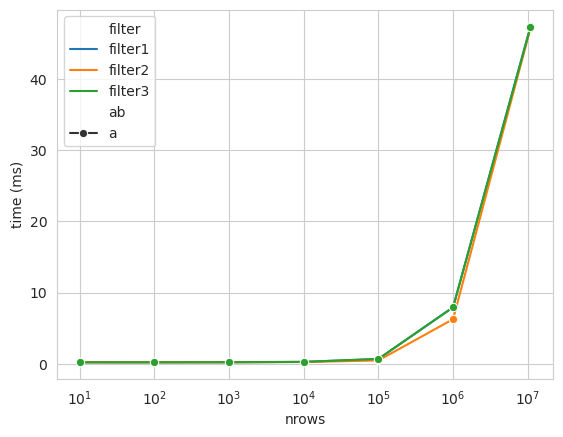

In [11]:
def time_vs_df_size(df, nrows, ab=True):
    sns.set_style('whitegrid')
    df = df[df['ab'] == 'a']
    df = df[df['filter'] != 'filter4']
    
    if ab:
        ax = sns.lineplot(data=df[df['sk_size'] == 1], x='nrows', y='time (ms)', hue='filter', style='ab', markers=True)
    else:
        ax = sns.lineplot(data=df[df['sk_size'] == 1], x='nrows', y='time (ms)', hue='filter', markers=True)

    ax.set_xscale('log')
    # ax.set_yscale('log')
    plt.show()
    
time_vs_df_size(df_equals, 10_855_959)
time_vs_df_size(df_isin, 10_855_959)

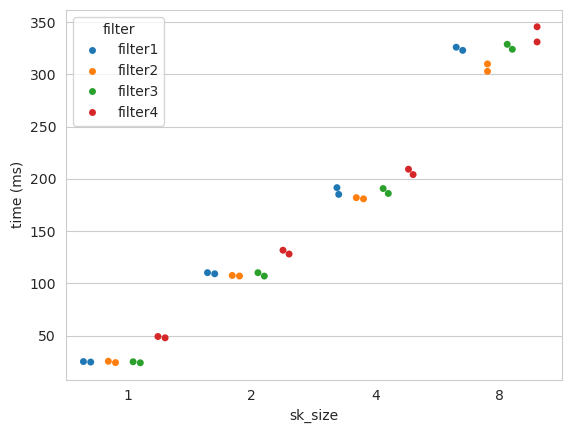

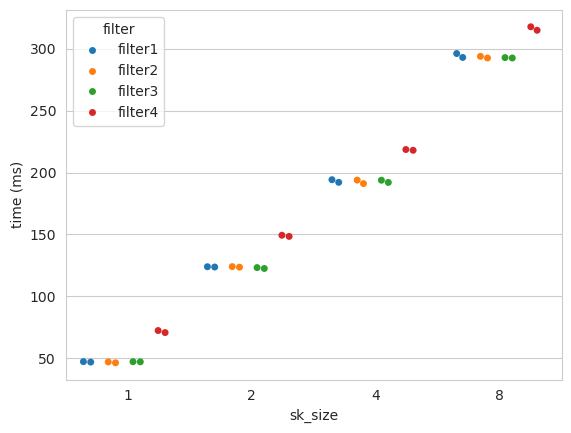

In [12]:
def time_vs_sketch_swarm(df, nrows):
    sns.set_style('whitegrid')
    ax = sns.swarmplot(data=df[df['nrows'] == nrows], x='sk_size', y='time (ms)', hue='filter', dodge=True)
    
    plt.show()
    
time_vs_sketch_swarm(df_equals, 10_855_959)
time_vs_sketch_swarm(df_isin, 10_855_959)

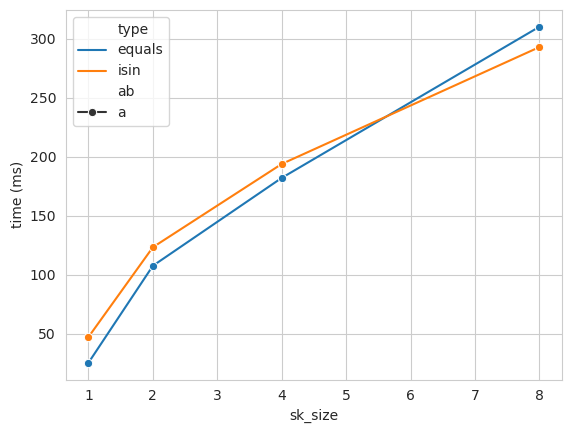

In [13]:
df_equals_best = df_equals[(df_equals['nrows'] == 10_855_959) & (df_equals['filter'] == 'filter2')]
df_isin_best = df_isin[(df_isin['nrows'] == 10_855_959) & (df_isin['filter'] == 'filter3')]

df_equals_best = df_equals_best.assign(type='equals')
df_isin_best = df_isin_best.assign(type='isin')

df_eq_in = pd.concat([df_equals_best, df_isin_best], axis=0)

sns.set_style('whitegrid')
ax = sns.lineplot(data=df_eq_in[df_eq_in['ab'] == 'a'], x='sk_size', y='time (ms)', hue='type', style='ab', markers=True)

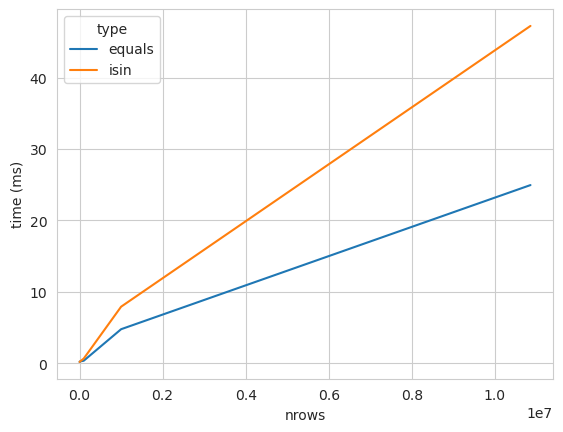

In [14]:
df_equals_best = df_equals[(df_equals['sk_size'] == 1) & (df_equals['filter'] == 'filter3')]
df_isin_best = df_isin[(df_isin['sk_size'] == 1) & (df_isin['filter'] == 'filter3')]

df_eq_in = pd.concat([df_equals_best.assign(type='equals'), df_isin_best.assign(type='isin')], axis=0)

sns.set_style('whitegrid')
ax = sns.lineplot(data=df_eq_in[df_eq_in['ab'] == 'a'], x='nrows', y='time (ms)', hue='type', markers=True)

## `filter_timing_multi.log`

In [15]:
    
def read_filter_multi_log():
    f = open('filter_timing_multi.log', 'r')
    raw_data = f.read()
    f.close()
    
    raw_data = raw_data.split('NUM ROWS')[1:]
    
    df = pd.DataFrame(columns=['nrows', 'sk_size', 'mi_time (ms)', 'mi_mem', 'df_mem', 'mi_mem_units', 'df_mem_units'])
    
    num_rows = [10, 100, 1000, 10_000, 100_000, 1_000_000, 10_855959]
    sketch_sizes = [1, 2, 4, 8]
    filters = ['filter1', 'filter2', 'filter3', 'filter5']
    
    for irows, nrows in enumerate(num_rows):
        mi_data, filter_data = raw_data[irows].split('//////////')

        # Process filter data
        for isk, sk_size in enumerate(sketch_sizes):
            raw_data_i = filter_data.split('**********')
            s = pd.Series(raw_data_i[isk])

            regex_time = r'filter\d time: (\d+.\d+) ms'
            regex_size = r'filter\d size: \((\d+, \d+)\)'

            dfi_time = s.str.extractall(regex_time)
            dfi_size = s.str.extractall(regex_size)

            idx_level_0 = pd.Index([sk_size] * len(dfi_time), name='sk_size')
            idx_level_1 = pd.Index(dfi_time.index.levels[1].map(dict(zip(range(len(filters)), filters))), name='filter')

            dfi_time = dfi_time.set_index([idx_level_0, idx_level_1]).set_axis(['time (ms)'], axis=1)
            dfi_size = dfi_size.set_index([idx_level_0, idx_level_1]).set_axis(['size'], axis=1)

            dfi = dfi_time.reset_index().merge(dfi_size.reset_index(), on=['sk_size', 'filter'])
            dfi['nrows'] = nrows
            
            df = pd.concat([df, dfi])
        
        # Process MultiIndex data
        regex_mi_time = r'multiindex time: (\d+.\d+) ms'
        regex_mem = r'memory usage: (\d+\.\d+)\+* (.*)'
        
        s = pd.Series(mi_data)
        
        df.loc[df['nrows'] == nrows, 'mi_time (ms)'] = s.str.extractall(regex_mi_time).values
        df.loc[df['nrows'] == nrows, ['df_mem', 'df_mem_units']] = s.str.extractall(regex_mem).values[0]
        df.loc[df['nrows'] == nrows, ['mi_mem', 'mi_mem_units']] = s.str.extractall(regex_mem).values[1]
    
        def mi_mem_to_mb(row):
            mem, units = row['mi_mem'], row['mi_mem_units']
            if units == 'bytes':
                return float(mem) / 1024**2
            elif units == 'KB': 
                return float(mem) / 1024
            if units == 'MB':
                return float(mem)
            elif units == 'GB':
                return float(mem) * 1024
            else:
                return np.nan
            
        def df_mem_to_mb(row):
            mem, units = row['df_mem'], row['df_mem_units']
            if units == 'bytes':
                return float(mem) / 1024**2
            elif units == 'KB': 
                return float(mem) / 1024
            if units == 'MB':
                return float(mem)
            elif units == 'GB':
                return float(mem) * 1024
            else:
                return np.nan
    
        df['mi_mem (MB)'] = df.apply(mi_mem_to_mb, axis=1)
        df['df_mem (MB)'] = df.apply(df_mem_to_mb, axis=1)
    
    df['nrows'] = df['nrows'].astype(int)
    df['sk_size'] = df['sk_size'].astype(int)
    df['time (ms)'] = df['time (ms)'].astype(float)
    df['mi_time (ms)'] = df['mi_time (ms)'].astype(float)
    df['mi_mem (MB)'] = df['mi_mem (MB)'].astype(float)
    df['df_mem (MB)'] = df['df_mem (MB)'].astype(float)
    
    return df

df_multi = read_filter_multi_log()
df_multi

,nrows,sk_size,mi_time (ms),mi_mem,df_mem,mi_mem_units,df_mem_units,filter,time (ms),size,mi_mem (MB),df_mem (MB)
0,10,1,1.564370,1.1,992.0,KB,bytes,filter1,0.158623,"5, 10",0.001074,0.000946
1,10,1,1.564370,1.1,992.0,KB,bytes,filter2,0.182833,"5, 10",0.001074,0.000946
2,10,1,1.564370,1.1,992.0,KB,bytes,filter3,0.157331,"5, 10",0.001074,0.000946
3,10,1,1.564370,1.1,992.0,KB,bytes,filter5,0.145413,"5, 10",0.001074,0.000946
0,10,2,1.564370,1.1,992.0,KB,bytes,filter1,0.071651,"10, 10",0.001074,0.000946
...,...,...,...,...,...,...,...,...,...,...,...,...
3,10855959,4,1117.933855,466.8,414.1,MB,MB,filter5,35.806042,"4530415, 10",466.800000,414.100000
0,10855959,8,1117.933855,466.8,414.1,MB,MB,filter1,361.317679,"8522399, 10",466.800000,414.100000
1,10855959,8,1117.933855,466.8,414.1,MB,MB,filter2,360.715823,"8522399, 10",466.800000,414.100000
2,10855959,8,1117.933855,466.8,414.1,MB,MB,filter3,362.427426,"8522399, 10",466.800000,414.100000


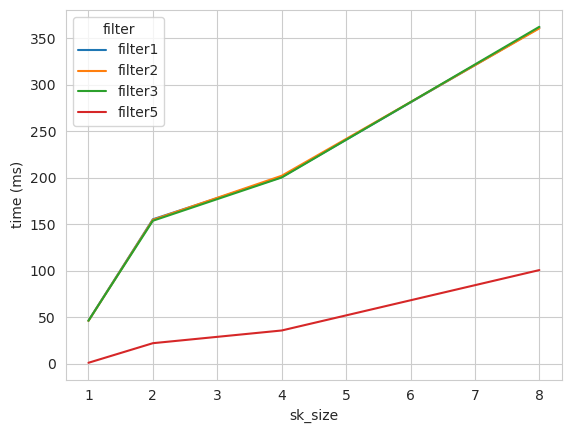

In [16]:
time_vs_sketch_size(df_multi, 10_855_959, ab=False)

[None, None]

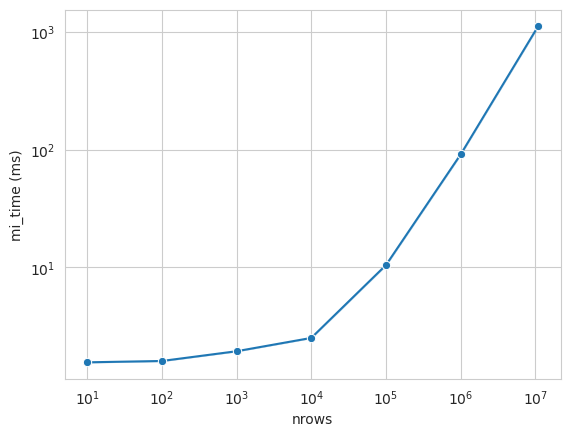

In [17]:
sns.set_style('whitegrid')
ax = sns.lineplot(data=df_multi, x='nrows', y='mi_time (ms)', marker='o')
ax.set(xscale='log', yscale='log')

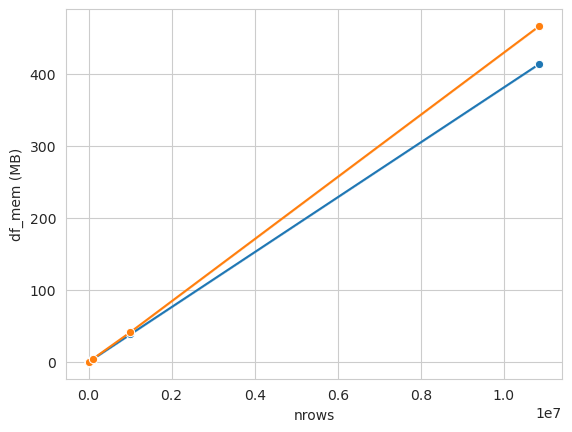

In [18]:
sns.set_style('whitegrid')
ax = sns.lineplot(data=df_multi, x='nrows', y='df_mem (MB)', marker='o')
ax = sns.lineplot(data=df_multi, x='nrows', y='mi_mem (MB)', marker='o')
# ax.set(xscale='log', yscale='log')

[None, None]

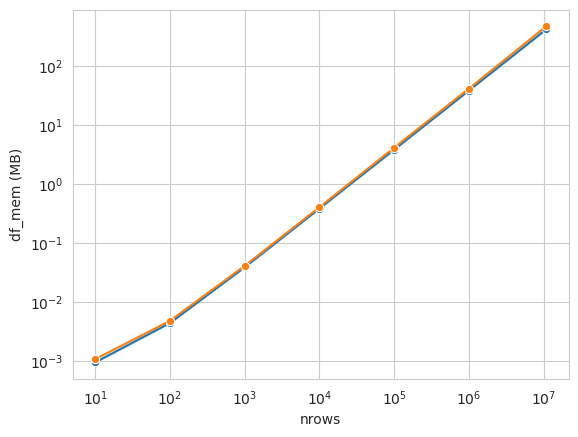

In [19]:
sns.set_style('whitegrid')
ax = sns.lineplot(data=df_multi, x='nrows', y='df_mem (MB)', marker='o')
ax = sns.lineplot(data=df_multi, x='nrows', y='mi_mem (MB)', marker='o')
ax.set(xscale='log', yscale='log')

# `max_flux_timing.log`

In [45]:
def read_max_flux_log():
    f = open('max_flux_timing.log', 'r')
    raw_data = f.read()
    f.close()
    
    raw_data = raw_data.split('NUM ROWS')[1:]
    
    df = pd.DataFrame(columns=['nrows', 'query_type', 'time (ms)', 'result'])

    num_rows = [10, 100, 1000, 10_000, 100_000, 1_000_000, 10_855959]
    queries = ['unfiltered', 'filtered', 'multiindex']

    for irows, nrows in enumerate(num_rows):
        raw_data_i = raw_data[irows].split('ms')
        s = pd.Series(raw_data_i)

        result = s.str.extractall(r'result: (\d+.\d+)')
        time = s.str.extractall(r'time: (\d+.\d+)')
        
        dfi = pd.DataFrame(columns=['nrows', 'query_type', 'time (ms)', 'result'])
        
        dfi['time (ms)'] = time[0].astype(float)
        dfi['result'] = result[0].astype(float)
        dfi['nrows'] = nrows
        dfi['query_type'] = queries
                
        df = df.merge(dfi, how='outer')
    
    return df

df = read_max_flux_log()
# df.to_csv('max_flux_timing.csv')
df

,nrows,query_type,time (ms),result
0,10,filtered,0.386616,6.032414
1,10,multiindex,0.531254,6.032414
2,10,unfiltered,0.102348,6.032414
3,100,filtered,0.433245,10.847942
4,100,multiindex,0.521500,10.847942
5,100,unfiltered,0.099057,10.847942
6,1000,filtered,0.417810,45.070511
7,1000,multiindex,0.710254,45.070511
8,1000,unfiltered,0.104046,45.070511
9,10000,filtered,0.559512,173.559006


[None, None]

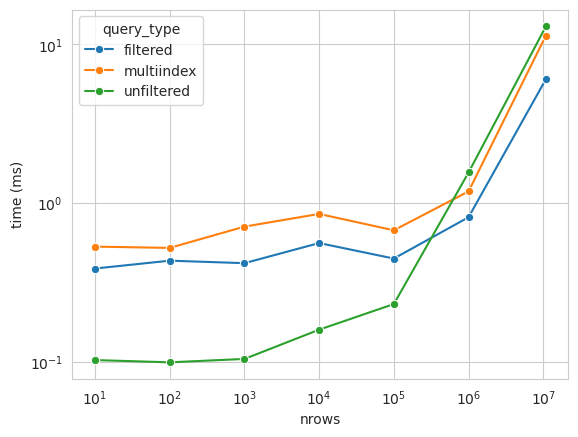

In [48]:
sns.set_style('whitegrid')
ax = sns.lineplot(data=df, x='nrows', y='time (ms)', hue='query_type', marker='o')
ax.set(xscale='log', yscale='log')